# Recommender System using Matrix Factorisation

<!-- ### What this project does -->

<!-- ### What this project doesn't do -->

In [1]:
####### For working on Google Colab #######
# Uncomment the appropriate block below

#### Download and unzip the 100k ratings Movielens dataset
# !curl -O http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !unzip ml-latest-small.zip
# !cd ml-latest-small/

#### Download and unzip the 10 million ratings Movielens dataset
# !curl -O https://files.grouplens.org/datasets/movielens/ml-10m.zip
# !unzip ml-10m.zip
# !cd ml-10M100K/

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import ipywidgets
!jupyter nbextension enable --py widgetsnbextension
%matplotlib inline

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<!-- Until now, I've encountered two types of data objects in the Pandas library—DataFrames and Series, and here is a [Scaler Topics article on core components of Pandas](https://www.scaler.com/topics/pandas/core-components-of-pandas/), confirming that these two are the important ones (for single-dimensional, and two-dimensional data respectively), apart from a third object type, `Panel` (for three-dimensional data).

Here's a micro-article attempting to list the organisation of files in Pandas' architecture: [Discover Pandas Library Architecture – File Hierarchy in Pandas](https://data-flair.training/blogs/pandas-library-architecture/) -->


In [3]:
ratings_df = pd.read_csv("./ml-latest-small/ratings.csv")
# ratings_df = pd.read_csv("./ml-10M100K/ratings.dat", delimiter='::', names=['userId', 'movieId', 'rating', 'timestamp'])
# ratings_df = pd.read_csv("./anime-ratings-matrix-factorization-v-10/anime ratings dataset/rating.csv")

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
# num_movies = pd.DataFrame(ratings_df['movieId'].unique()).count().values[0]       #this is a tad more convoluted way
# num_users = pd.DataFrame(ratings_df['userId'].unique()).count().values[0]
num_movies = ratings_df['movieId'].unique().shape[0]                                #better way
num_users = ratings_df['userId'].unique().shape[0]
print(f"There are {num_movies} movies and {num_users} users in the dataset")

There are 9724 movies and 610 users in the dataset


In [7]:
print(f"There are {ratings_df.loc[ratings_df.userId > num_users].userId.unique().shape[0]} user IDs exceeding {num_users}.")
print(f"There are {ratings_df.loc[ratings_df.movieId > num_movies].movieId.unique().shape[0]} movie IDs exceeding {num_movies}.")

There are 0 user IDs exceeding 610.
There are 4334 movie IDs exceeding 9724.


For the 100k ratings dataset: it seems that the user IDs are contiguous, while the movie IDs are not.

For the 10M ratings dataset: both the user IDs and movie IDs are not contiguous.

We shall make the requisite IDs contiguous in following blocks after some more EDA.

In [8]:
# ratings_df.describe().T

In [9]:
# pd.Series.value_counts(ratings_df['rating']).to_frame().T

In [10]:
# plt.hist(ratings_df['rating'], bins=[(i-1)/2 for i in range(0, 12)])
# plt.hist(ratings_df['rating'], bins=[i-0.5 for i in range(-1,12)])  #for anime ratings dataset

In [11]:
print( ratings_df.isna().sum() , "\n")
print( type(ratings_df.isna().sum()) )

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

<class 'pandas.core.series.Series'>


In [12]:
print( len(ratings_df.duplicated(subset=['userId', 'movieId'])) )
len(np.where( ratings_df.duplicated(subset=['userId', 'movieId']) == False )[0])

100836


100836

There don't seem to be any duplicates *shruggie

In [13]:
# toy = np.zeros((3,4))
# toy[0,1] = 1
# toy[2,3] = 2
# toy

In [14]:
# toy_csc = sparse.csc_matrix(toy)
# print( toy_csc.data )
# print( toy_csc.nnz )  # nnz => no. of non-zero (entries)
# print( toy_csc.nonzero() )

In [15]:
# toy_csc.power(2).todense()

In [16]:
############################################################################
## This was an unsuccessful attempt to write a general function to make IDs contiguous ##
############################################################################

# def make_id_contiguous(df:pd.DataFrame, id:str):
#        old_new_id = np.zeros(df[id].max()+1)
#        for new_id, old_id in enumerate(df[id].unique()):
#               old_new_id[old_id] = new_id
              
#        import re
#        RE_WORDS = re.compile(r'''
#                      # Find words in a string. Order matters!
#                      [A-Z]+(?=[A-Z][a-z]) |  # All upper case before a capitalized word
#                      [A-Z]?[a-z]+ |  # Capitalized words / all lower case
#                      [A-Z]+ |  # All upper case
#                      \d+  # Numbers
#                      ''', re.VERBOSE)
#        id_split = RE_WORDS.findall(id)
#        print(id_split)
#        print(np.where(id_split == 'Id'))
#        # id_split[np.where(id_split == 'Id')] = 'newId'
#        new_id_name = "".join(i for i in id_split)

#        df[new_id_name] = old_new_id[df[id]]
#        df = df.astype({new_id_name: 'int64'})
#        print( df.head(), "\n" )
#        return old_new_id

# make_id_contiguous(ratings_df, 'movieId')

### Making the user and movie IDs contiguous

In [17]:
user_old_new_id = np.zeros(ratings_df["userId"].max()+1)
for new_id, old_id in enumerate(ratings_df['userId'].unique()):
       user_old_new_id[old_id] = new_id
       
ratings_df['userNewId'] = user_old_new_id[ratings_df['userId']]
ratings_df = ratings_df.astype({'userNewId': 'int64'})

print( ratings_df.head(), "\n" )
# now just to check that we did it correctly, a movieId should be mapped to the same movieNewId
print( ratings_df.loc[ratings_df.userId == 156][['userId', 'userNewId']], "\n" ) 
print(f"There are {num_users} users and correspondingly {max(user_old_new_id)+1} contiguous user IDs now")

   userId  movieId  rating  timestamp  userNewId
0       1        1     4.0  964982703          0
1       1        3     4.0  964981247          0
2       1        6     4.0  964982224          0
3       1       47     5.0  964983815          0
4       1       50     5.0  964982931          0 

       userId  userNewId
22684     156        155
22685     156        155
22686     156        155
22687     156        155
22688     156        155
...       ...        ...
23077     156        155
23078     156        155
23079     156        155
23080     156        155
23081     156        155

[398 rows x 2 columns] 

There are 610 users and correspondingly 610.0 contiguous user IDs now


In [18]:
movie_old_new_id = np.zeros(ratings_df["movieId"].max()+1)
for new_id, old_id in enumerate(ratings_df['movieId'].unique()):
       movie_old_new_id[old_id] = new_id
       
ratings_df['movieNewId'] = movie_old_new_id[ratings_df['movieId']]
ratings_df = ratings_df.astype({'movieNewId': 'int64'})

print( ratings_df.head(), "\n" )
# now just to check that we did it correctly, a movieId should be mapped to the same movieNewId
print( ratings_df.loc[ratings_df.movieId == 156][['movieId', 'movieNewId']], "\n" ) 
print(f"There are {num_movies} movies and correspondingly {max(movie_old_new_id)+1} contiguous movie IDs now")

   userId  movieId  rating  timestamp  userNewId  movieNewId
0       1        1     4.0  964982703          0           0
1       1        3     4.0  964981247          0           1
2       1        6     4.0  964982224          0           2
3       1       47     5.0  964983815          0           3
4       1       50     5.0  964982931          0           4 

       movieId  movieNewId
17007      156        4463
96137      156        4463
97391      156        4463 

There are 9724 movies and correspondingly 9724.0 contiguous movie IDs now


In [19]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)  #setting random_state ensures consistent splitting every time

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df)
print(test_df)
print( np.shape(train_df), np.shape(test_df) )

       userId  movieId  rating   timestamp  userNewId  movieNewId
0         509     7347     3.0  1435994597        508        4285
1         326    71462     4.0  1322252335        325        5629
2          57     2115     3.0   965798155         56         134
3         610     1127     4.0  1479544102        609          66
4         462     2409     2.0  1174438249        461        1172
...       ...      ...     ...         ...        ...         ...
80663      42     4005     4.0   996259059         41        1873
80664     364      141     4.0   869443367        363         524
80665     480     6867     4.0  1179163171        479        2240
80666       6      981     3.0   845556567          5         712
80667     103     6711     5.0  1431957425        102        2046

[80668 rows x 6 columns]
       userId  movieId  rating   timestamp  userNewId  movieNewId
0         432    77866     4.5  1335139641        431        4730
1         288      474     3.0   978465565        

Since we've chosen to make the movie IDs contiguous by mapping them to new ones, splitting the DataFrame makes creating smaller-dimensional matrix representations of the training or test sets difficult, because, say, the indices chosen in the training set can still lie out of bounds of its smaller matrix's size (similar logic holds for the test set).

Instead, let's just work with the full ratings matrix, with the test entries zeroed out in the training matrix (and vice versa), which wouldn't be a bother to the memory anyway because we're using a sparse representation!

In [20]:
train = sparse.csc_matrix( (train_df['rating'].values, (train_df['userNewId'].values, train_df['movieNewId'].values)),\
                                 shape=(num_users+1, num_movies+1) )
test = sparse.csc_matrix(  (test_df['rating'].values, (test_df['userNewId'].values, test_df['movieNewId'].values)),\
                                 shape=(num_users+1, num_movies+1))

print(f"There are {train.nnz} & {test.nnz} non-zero elements in the train and test sparse matrices respectively.\n", test.shape[0],train.shape[1] )
# train.to_dense()
# print( train )

There are 80668 & 20168 non-zero elements in the train and test sparse matrices respectively.
 611 9725


Lemme check once that the test and train matrix elements are indeed mutually exclusive (zero, non-zero in their matrices respectively).

The cell below seems to show all's good

In [21]:
# for i in zip(test.nonzero()[0], test.nonzero()[1]):
#        if( train[i[0],i[1]] != 0 ):
#               print("Hah!")
# for i in zip(train.nonzero()[0], train.nonzero()[1]):
#        if( test[i[0],i[1]] != 0 ):
#               print("Hah!")

In [22]:
# print( np.sort(train_df['userId'].values) )
# print( mf.p_nnz_idx, "\n" )

# print( np.sort(train_df['movieNewId'].values) )
# print( np.sort(mf.q_nnz_idx ) )
# print( np.sort(train_df['userId'].values) == mf.p_nnz_idx )
# print( np.sort(train_df['movieNewId'].values) == np.sort(mf.q_nnz_idx), "\n" )

# print( np.where( np.sort(train_df['userId'].values) != train.nonzero()[0]) )
# print( np.where( np.sort(train_df['movieNewId'].values) != np.sort( train.nonzero()[1]) ) )
# print( np.where( np.sort(train_df['movieNewId'].values) != np.sort(mf.q_nnz_idx)) )


Hmmm, so the row indices seem to be all good, ~~but the column indices are playing foul.~~ as do the column indices.

Wasted quite the time pursuing this!

We have used the list `train_df['movieNewId'].values` as the column indices needed to generate R, but upon querying back these column indices, ~~they're coming out wrong!~~
Previously, I wasn ony sorting the `train_df['movieNewId'].values` list, and not the list `mf.q_nnz_idx` for comparison. Upon sorting both, they indeed come out to be the same.
***

## Matrix Factorisation Class
Below, I furnish a Matrix Factorisation Python class that implements:
- gradient descent
- (pending) gradient descent with user and item biases
- sgd
- ALS
to learn the embeddings.

The implementation of gradient descent and sgd considers the loss function for explicit ratings, i.e. solely over observed values.
The ALS implementation uses the Koren et al. approach treating the entire ratings matrix as dense implicit data.

The regularised loss I've used for explicit ratings: $$L(R, P, Q) = \frac{1}{N}\underset{(i,j):r_{ui}≠Nan}{\sum} (r_{ui} - p_u^T\cdot q_i)^2 + \lambda(\sum_u{||p_u||^2} + \sum_i{||q_i||^2})$$
It's a squared error (SE) loss function with regularisation terms. I wonder how using the Mean SE or RMSE would change the behaviour. ~~Conceptually, it shouldn't..~~ Oh how pathetically wrong I was! Not providing the required normalisation on the gradient terms just blew the cost up! I wonder why not providing the normalisation to the gradient calculation blows up the cost. The two seem unrelated, except, not!

Still need to add the user and item bias terms to SGD and GD.

In [55]:
class MatrixFactorisation():
       def __init__(self, R:sparse.csc_matrix, k:int, verbose:bool=False ):
              self.R = R           # R is the "ratings" matrix to be factorised
              self.k = k           # hyperparameter k is the number of latent factors desired in the factorised embeddings
              self.m, self.n = R.shape
              self.P = np.random.rand(self.m, k)        # initialising the first factor embedding (of "users")
              self.Q = np.random.rand(self.n, k)        # initialising the second factor embedding (of "items")
              self.p_nnz_idx, self.q_nnz_idx = R.nonzero()        # row and col indices in R matrix respectively, of non-zero elements
              self.train_mse_at_epochs = []
              self.test_mse_at_epochs = []
              self.verbose = verbose
              self.verbose_epoch_intvl = 50

       def __predict_observed(self):
              """
              Returns predicted values as a sparse matrix, corresponding to indices of non-zero elements in matrix R to be factorised

              Avoids constructing a dense prediction matrix produced via naïve dense matrix multiplication of factors.
              Instead, produces predicted values by multiplying only the requisite factor vectors corresponding to non-zero entries in R.
              """
              R_predicted = np.sum( np.multiply(self.P[self.p_nnz_idx], self.Q[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries: explicit MF
              R_predicted = sparse.csc_matrix( (R_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))              
              # R_predicted = self.P @ self.Q.T
              # R_predicted = sparse.csc_matrix(R_predicted)
              return R_predicted

       def gradients(self, _lambda):
              """
              Returns l2 gradients w.r.t the elements of the embedding vectors, along with the prediction errors
              """
              R_predicted = self.__predict_observed()
              error = self.R - R_predicted
              norm_factor = -2 / self.R.nnz  #this factor is crucial! Can't be 1 (i.e. we can't leave the gradients unnormalised, else cost diverges!)
              grad_P = norm_factor * (error*self.Q) + 2*(_lambda*self.P)
              grad_Q = norm_factor * (error.T*self.P) + 2*(_lambda*self.Q)
              return grad_P, grad_Q, error

       def gradient_descent(self, iterations=2000, learning_rate = 0.3, _lambda=0.0002, beta=0.8, validation:sparse.csc_matrix=None, verbose=False):
              """
              Returns factor matrices for explicit data matrix by learning their entries via full-batch gradient descent.

              Returned factor matrices P,Q represent user and item embeddings, for explicit ratings data R.
                     R = P.Q^T

              Optionally provide a sparse matrix with validation data, to compute the validation performance (measured by mse) over time
              """
              self.verbose = verbose

              grad_P, grad_Q, error = self.gradients(_lambda)
              v_P = grad_P
              v_Q = grad_Q
              beta = beta    # momentum constant
              train_mse = error.power(2).sum()/self.R.nnz #self.R.shape[0]
              # print("train mse:", train_mse)
              self.train_mse_at_epochs.append( [1, train_mse] )
              self.save_test_mse(0, validation=validation)
              for i in tqdm(range(iterations), desc="Gradient Descent progress:", leave=verbose):
                     grad_P, grad_Q, error = self.gradients(_lambda)
                     v_P = beta*v_P + (1-beta)*grad_P   
                     v_Q = beta*v_Q + (1-beta)*grad_Q
                     self.P = self.P - learning_rate*v_P       # Grad Desc update rule
                     self.Q = self.Q - learning_rate*v_Q       # Grad Desc update rule
                     # print("train mse:", error.power(2).sum()/self.R.shape[0] )  #print mse at each iteration
                     if(not (i+1)%self.verbose_epoch_intvl):
                            self.save_train_mse(i, error)
                            self.save_test_mse(i, validation=validation)
              return self.P, self.Q

       def save_train_mse(self, i, error):
              train_mse = error.power(2).sum()/self.R.nnz #self.R.shape[0]
              self.train_mse_at_epochs.append( [i+1, train_mse])
              if(self.verbose):
                     print("\niteration/epoch", i+1, ":")
                     print("train mse:", train_mse)

       def save_test_mse(self, i, validation:sparse.csc_matrix=None, solver='gd'):
              if(validation != None):
                     valdn_p_nnz_idx, valdn_q_nnz_idx = validation.nonzero()
                     valdn_predicted = np.sum( np.multiply(self.P[valdn_p_nnz_idx], self.Q[valdn_q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     valdn_predicted = sparse.csc_matrix( (valdn_predicted, (valdn_p_nnz_idx, valdn_q_nnz_idx)), shape=(self.m,self.n))
                     # if(solver == 'als'):
                     #        valdn_Phi = validation
                     #        valdn_Phi[valdn_Phi.nonzero()] = 1.0
                     #        valdn_error = valdn_Phi- valdn_predicted
                     #        # test_mse = valdn_error.power(2).sum()/self.R.nnz   #self.R.shape[0]
                     # else:
                     #        # valdn_p_nnz_idx, valdn_q_nnz_idx = validation.nonzero()
                     #        # valdn_predicted = np.sum( np.multiply(self.P[valdn_p_nnz_idx], self.Q[valdn_q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     #        # valdn_predicted = sparse.csc_matrix( (valdn_predicted, (valdn_p_nnz_idx, valdn_q_nnz_idx)), shape=(self.m,self.n))
                     valdn_error = validation - valdn_predicted
                     test_mse = valdn_error.power(2).sum()/self.R.nnz   #self.R.shape[0]
                     self.test_mse_at_epochs.append([i+1, test_mse])
                     if(self.verbose):
                            print("iteration", i+1, ":")
                            print("test mse:", test_mse)

       def sgd(self, epochs=10, learning_rate=0.03, _lambda=0.0, beta=0.8, verbose=False, validation:sparse.csc_matrix=None):
              """
              Returns factor matrices for explicit data matrix by learning their entries via stochastic gradient descent.

              Returned factor matrices P,Q represent user and item embeddings, for explicit ratings data R.
                     R = P.Q^T
              """
              self.verbose = verbose
              beta = beta

              num_samples = len(self.p_nnz_idx)
              training_indices = np.arange(num_samples)
              # I couldn't have shuffled the array p_nnz_idx itself, cuz that would require shuffling q_nnx_idx in a corresponding manner

              # with tqdm(total=100) as prog_bar:
              for epoch in tqdm(range(epochs), desc="Total SGD epochs completion: ", leave=verbose):
                     np.random.shuffle(training_indices)       #stochasticity must be ensured properly!
                     count = 0
                     for i in tqdm(training_indices, desc=f"Epoch #{epoch} completion: "):         #We need to update all users and items at least once in each iteration
                            p_idx = self.p_nnz_idx[i]
                            q_idx = self.q_nnz_idx[i]

                            R_ij = self.R[p_idx, q_idx]
                            P_i = self.P[p_idx]
                            Q_j = self.Q[q_idx]

                            R_predicted_ij = P_i.dot(Q_j.T)
                            error_ij = R_ij - R_predicted_ij
                            grad_P_i = -2*(error_ij * Q_j) + 2*(_lambda * self.P[p_idx])
                            grad_Q_j = -2*(error_ij * P_i) + 2*(_lambda * self.Q[q_idx])

                            v_P_i = beta*v_P_i + (1-beta)*grad_P_i if epoch!=0 else grad_P_i
                            v_Q_j = beta*v_Q_j + (1-beta)*grad_Q_j if epoch!=0 else grad_Q_j
       
                            self.P[p_idx] -= learning_rate * v_P_i
                            self.Q[q_idx] -= learning_rate * v_Q_j
                            # self.P[p_idx] -= learning_rate* grad_P_i
                            # self.Q[q_idx] -= learning_rate* grad_Q_j

                            if(not ((epoch+1)*(count+1)+1)%(1000)):
                                   R_predicted = np.sum( np.multiply(self.P[self.p_nnz_idx], self.Q[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                                   R_predicted = sparse.csc_matrix( (R_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))
                                   error = self.R - R_predicted
                                   self.save_train_mse((epoch+1)*(count+1), error)
                                   self.save_test_mse((epoch+1)*(count+1), validation=validation)
                            count += 1

                     # if(not (epoch+1)%(self.verbose_epoch_intvl/10)):
                     #        R_predicted = np.sum( np.multiply(self.P[self.p_nnz_idx], self.Q[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     #        R_predicted = sparse.csc_matrix( (R_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))
                     #        error = self.R - R_predicted
                     #        self.save_train_mse(count, error)
                     #        # self.save_test_mse(i, validation=validation)
              return self.P, self.Q

       def als(self, epochs=10, alpha=40, _lambda=10, solver="cg", validation:sparse.csc_matrix=None, verbose=False):
              """
              Returns factor matrices for implicit data matrix by learning their entries via Alternating Least Squares method.

              Returned factor matrices P,Q represent user and item embeddings, for binarised ratings data Phi derived from R.
                     Phi[p,q] =    { 0    for R[p,q]=0
                                   { 1    for R[p,q]>0
              &      Phi = P.Q^T

              Uses scipy.sparse.linalg's spsolve as its solver
              """
              ## should I be making the following tradeoff for precomputed memory, to speed up implementation?
              # Cp_array = []
              # Cq_array = []
              # for p in range(self.m):
              #        C_p = sparse.diags(self.R[p].toarray(), [0])
              #        Cp_array.append(C_p)
              # for q in range(self.n):
              #        C_q = sparse.diags(self.R[q].toarray(), [0])
              #        Cq_array.append(C_q)
              self.verbose = verbose
              lambda_eye = _lambda * sparse.eye(self.k)

              P = sparse.csc_matrix(self.P)
              Q = sparse.csc_matrix(self.Q)

              # the memory for this loop can further be optimised by eliminating the two similar loops with appropriate conditioning
              for i in tqdm(range(epochs), desc="ALS iterations completion: "):
                     # Q = sparse.csc_matrix(self.Q)
                     QTQ = Q.T.dot(Q)         #precomputation of Q.T.dot(Q) for all elements of P
                     for p in tqdm(range(self.m), desc="Solving for P: ", leave=True):
                            R_p = self.R[p].toarray()
                            CpI = sparse.diags(alpha * R_p, [0])      #This acts as the (C^u - I) matrix in literature
                            QTCpIQ = Q.T.dot(CpI).dot(Q)
                            A = (QTQ + QTCpIQ) + lambda_eye

                            phi = R_p.copy()
                            phi[np.where(phi != 0)] = 1.0
                            b = Q.T.dot(CpI + sparse.eye(self.n)).dot(sparse.csc_matrix(phi).T)       # why the last transpose on phi though?

                            if(solver == "lu"):
                                   P[p] = sparse.linalg.spsolve(A, b)
                                   # self.P[p] = sparse.linalg.spsolve(A, b)
                            if(solver == "cg"):
                                   P[p], exitcode = sparse.linalg.cg(A, b.toarray())
                                   if(exitcode):
                                          print(f"Conjugate Gradient Method couldn't converge properly, exited with convergence exitcode {exitcode}")
                     
                     # P = sparse.csc_matrix(self.P)
                     PTP = P.T.dot(P)         #precomputation of P.T.dot(P) for all elements of Q
                     for q in tqdm(range(self.n), desc="Solving for Q: "):
                            R_q = self.R[:,q].T.toarray()
                            CqI = sparse.diags(alpha * R_q, [0])      #This acts as the (C^u - I) matrix in literature
                            PTCqIP = P.T.dot(CqI).dot(P)
                            A = (PTP + PTCqIP) + lambda_eye

                            phi = R_q.copy()
                            phi[np.where(phi != 0)] = 1.0
                            b = P.T.dot(CqI + sparse.eye(self.m)).dot(sparse.csc_matrix(phi).T)       # why the last transpose on phi though?

                            if(solver == "lu"):
                                   Q[q] = sparse.linalg.spsolve(A, b)
                                   # self.Q[q] = sparse.linalg.spsolve(A, b)
                            if(solver == "cg"):
                                   Q[q], exitcode = sparse.linalg.cg(A, b.toarray())
                                   if(exitcode):
                                          print(f"Conjugate Gradient Method couldn't converge properly, exited with convergence exitcode {exitcode}")

                     # Phi_predicted = np.sum( np.multiply(self.P[self.p_nnz_idx], self.Q[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     # Phi_predicted = sparse.csc_matrix( (Phi_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))
                     Phi_predicted = np.sum( np.multiply(P.toarray()[self.p_nnz_idx], Q.toarray()[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     Phi_predicted = sparse.csc_matrix( (Phi_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))
                     Phi = self.R
                     Phi[Phi.nonzero()] = 1.0
                     error = Phi - Phi_predicted
                     self.save_train_mse(i, error)

                     valdn_p_nnz_idx, valdn_q_nnz_idx = validation.nonzero()
                     valdn_predicted = np.sum( np.multiply(P.toarray()[valdn_p_nnz_idx], Q.toarray()[valdn_q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     valdn_predicted = sparse.csc_matrix( (valdn_predicted, (valdn_p_nnz_idx, valdn_q_nnz_idx)), shape=(self.m,self.n))
                     valdn_Phi = validation
                     valdn_Phi[valdn_Phi.nonzero()] = 1.0
                     valdn_error = valdn_Phi- valdn_predicted
                     test_mse = valdn_error.power(2).sum()/self.R.nnz   #self.R.shape[0]
                     self.test_mse_at_epochs.append([i+1, test_mse])
                     if(self.verbose):
                            print("iteration", i+1, ":")
                            print("test mse:", test_mse)
              self.P = P
              self.Q = Q
              return self.P, self.Q

       def plot_learning_curve(self, validation=None):
              if(validation != None):
                     test_mse_arr = np.array(self.test_mse_at_epochs)
                     plt.plot(test_mse_arr[:,0], test_mse_arr[:,1], label='Test')
              train_mse_arr = np.array(self.train_mse_at_epochs)
              plt.plot(train_mse_arr[:,0], train_mse_arr[:,1], label='Train')
              plt.xticks(fontsize=16)
              plt.yticks(fontsize=16)
              plt.xlabel('iterations', fontsize=12)
              plt.ylabel('MSE', fontsize=12)
              plt.legend(loc='best', fontsize=9)


In [56]:
import itertools
def grid_search(model, train, test, param_grid, user_index=None):
    curves = []
    keys, values = zip(*param_grid.items())
    for v in tqdm(itertools.product(*values), desc="Grid Search Progress: "):
        # print(v)
        params = dict(zip(keys, v))
        mf = MatrixFactorisation(train, params["k"])
        params = dict(list(params.items())[1:])
        if(model == "als"):
            mf.als(**params, validation=test)
        elif(model == "gd"):
            mf.gradient_descent(**params, validation=test)
        elif(model == "sgd"):
            mf.sgd(**params, validation=test)

        train_mse = mf.train_mse_at_epochs
        test_mse = mf.test_mse_at_epochs

        curves.append({'params': params, 'mse': {'train': train_mse, 'test': test_mse}})

        print_line = []
        for k, v in params.items():
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        # _, train_patk, train_mse, test_patk, test_mse = learning_curve(this_model, train, test, epochs, k=patk, user_index=user_index)
        # curves.append({'params': params,
        #                'patk': {'train': train_patk, 'test': test_patk},
        #                'mse': {'train': train_mse, 'test': test_mse}})
    return curves

param_grid_als = {  "k": [20, 40, 80],
                    "alpha": [40, 50],
                    "_lambda": [0.0, 1e-1, 1e-2, 10]}
              
param_grid_gd = {   "k": [20, 40, 80],
                    "iterations": [1000, 3000, 10000],
                    "learning_rate": [0.3, 0.5],
                    # "beta": [0.5, 0.9],
                    "_lambda": [0.0, 1e-1, 1e-2, 10]}

param_grid_sgd = {  "k": [20, 40, 80],
                    "epochs": [2, 5, 10],
                    "learning_rate": [0.003, 0.03, 0.3],
                    # "beta": [0.5, 0.9],
                    "_lambda": [0.0, 1e-1, 1e-2, 10]}

curves = grid_search("sgd", train, test, param_grid_sgd)

Grid Search Progress: : 0it [00:00, ?it/s]

Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:126: RuntimeWarning: overflow encountered in multiply
  grad_Q_j = -2*(error_ij * P_i) + 2*(_lambda * self.Q[q_idx])
/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:125: RuntimeWarning: overflow encountered in multiply
  grad_P_i = -2*(error_ij * Q_j) + 2*(_lambda * self.P[p_idx])
/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:126: RuntimeWarning: invalid value encountered in multiply
  grad_Q_j = -2*(error_ij * P_i) + 2*(_lambda * self.Q[q_idx])
/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:125: RuntimeWarning: invalid value encountered in multiply
  grad_P_i = -2*(error_ij * Q_j) + 2*(_lambda * self.P[p_idx])
/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:137: RuntimeWarning: overflow encountered in multiply
  R_predicted = np.sum( np.multiply(self.P[self.p_nnz_idx], self.Q[self.q

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:131: RuntimeWarning: invalid value encountered in subtract
  self.P[p_idx] -= learning_rate * v_P_i


Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:132: RuntimeWarning: invalid value encountered in subtract
  self.Q[q_idx] -= learning_rate * v_Q_j


Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

/Users/kushagra/Py_VirtualEnvs/RecSys_Env/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_80136/3513287690.py:125: RuntimeWarning: overflow encountered in add
  grad_P_i = -2*(error_ij * Q_j) + 2*(_lambda * self.P[p_idx])


Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 2 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 5 | learning_rate: 0.3 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.003 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.03 | _lambda: 10


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.0


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.1


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 0.01


Total SGD epochs completion:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #1 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #2 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #3 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #4 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #5 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #6 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #7 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #8 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

Epoch #9 completion:   0%|          | 0/80668 [00:00<?, ?it/s]

epochs: 10 | learning_rate: 0.3 | _lambda: 10


#### Visualising the optimal hyperparameter learning curve

In [176]:
#### Weeding parameter mixes that resulted in algorithm divergence (inf, nan values for mse) ####
curves_copy = copy.deepcopy(curves)
for curve in curves_copy:
       mse = np.array(curve['mse']['test'])
       if(np.isnan(mse[:,1]).any()):
              to_rem = curve
              curves_copy.remove(to_rem)

#### Finding the best run via sorting by test_mse values
best_curves = sorted(curves_copy, key=lambda x: np.min(np.array(x['mse']['test'])[:,1]), reverse=False)  #for each curve, use the lowest test mse as its identity, for sorting the curves

# best_curves = sorted(curves_copy, key=lambda x: np.nanmin(np.array(x['mse']['test'])[:,1]), reverse=True)
# best_curves = sorted(curves_copy, key=lambda x: np.min(np.ma.masked_array(np.array(x['mse']['test']), np.isnan(np.array(x['mse']['test'])))), reverse=True)

In [194]:
rank = 1     # nth best rank of hyperparameter mix you want to see. n=1,2,..
bestParams = best_curves[rank-1]['params']
print(bestParams)

bestTimeVsTestMseArr = np.array(best_curves[rank-1]['mse']['test'])
bestTimeVsTrainMseArr = np.array(best_curves[rank-1]['mse']['train'])
# print( bestTimeVsTestMseArr )
min_loss = min(bestTimeVsTestMseArr[:,1])
print(min_loss)
iterations = bestTimeVsTestMseArr[:,0][np.where(bestTimeVsTestMseArr[:,1] == min_loss)]
print('Epoch: {}'.format(iterations))

{'epochs': 10, 'learning_rate': 0.03, '_lambda': 0.0}
0.0057034128039236374
Epoch: [721000.]


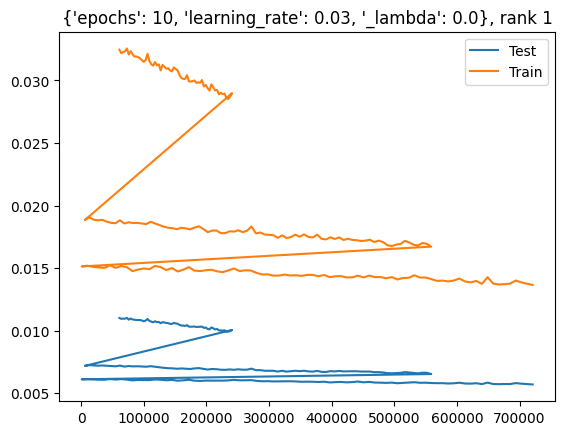

In [197]:
plt.plot(bestTimeVsTestMseArr[100:,0], bestTimeVsTestMseArr[100:,1], label="Test")
plt.plot(bestTimeVsTrainMseArr[100:,0], bestTimeVsTrainMseArr[100:,1], label="Train")
plt.title(f"{bestParams}, rank {rank}")
plt.xlabel("")
plt.rcdefaults()
plt.legend()

In [166]:
import pickle
with open("SGDGridSearch", "wb") as f:
       pickle.dump(curves, f)

In [ ]:
######--------- Training with ALS (Alternating Least Squares) ---------######

mf = MatrixFactorisation(train, 40)
print( np.shape(mf.P), np.shape(mf.Q) )
P, Q = mf.als(epochs=5, solver="cg", validation=test, verbose=True)

In [ ]:
######--------- Training with SGD (Stochastic Gradient Descent) ---------######

mf = MatrixFactorisation(train, 10)
print( np.shape(mf.P), np.shape(mf.Q) )
# print( mf.P )
P, Q = mf.sgd(epochs=10, learning_rate=0.03, _lambda=0.0, validation=test, verbose=False)
print(np.shape(P))

In [ ]:
######--------- Training with Gradient Descent ---------######

mf = MatrixFactorisation(train, 10)
print( np.shape(mf.P), np.shape(mf.Q) )
# print( mf.P )
P, Q = mf.gradient_descent(iterations=10000, learning_rate=0.4, _lambda=0, validation=test, verbose=False)
# print(np.shape(P))

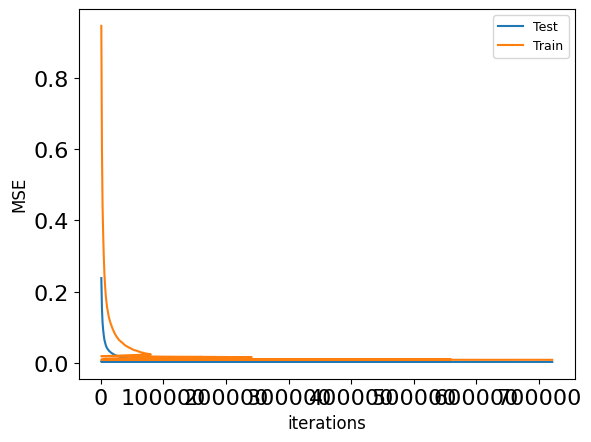

In [190]:
# print( np.array(mf.train_mse_at_epochs)[:,1] )
mf.plot_learning_curve(validation=True)
# mf.plot_learning_curve(validation=None)

## Roughwork...

In [ ]:
# help = np.zeros((mf.P.shape[0], mf.Q.T.shape[1]))
# print(np.shape(help))

# for i in range(mf.P.shape[0]):
#        for j in range(mf.Q.T.shape[1]):
#               for k in range(mf.k):
#                      help[i][j] += mf.P[i][k] * mf.Q.T[k][j]

# print(help)

In [ ]:
# help2 = mf.P @ mf.Q.T
print(mf.P,"\n\n\n\n", mf.Q)

[[-0.20473836  0.64551148  0.38983446 ...  0.23257534 -0.10078407
   0.51946697]
 [-0.03210454  0.4549741   0.20326194 ...  0.80037336  0.13764056
   0.3716281 ]
 [ 0.15991591  0.23314564  0.71370675 ...  0.18638087  0.73911567
   0.03055401]
 ...
 [ 0.08203674  0.766394    0.12699937 ...  0.51852963  0.69768505
   0.53541308]
 [ 0.2986957   0.47134367  0.00843501 ...  0.36027689 -0.1028373
   0.00712214]
 [ 0.89263219  0.64457093  0.85489007 ...  0.96491938  0.21266239
   0.86141308]] 



 [[ 0.18277182 -0.09247713  0.67162319 ...  0.4314283   0.58398668
   0.56219493]
 [ 0.60960645  0.38650404  0.08310481 ...  0.53197436  0.9441766
   0.87047294]
 [ 0.67215655  0.18874724  0.1152919  ... -0.04298182  0.08912164
   0.51268375]
 ...
 [ 0.35018881  0.20878879  0.36529109 ...  0.7042925   0.76731649
   0.37237964]
 [ 0.68886668  0.29020615  0.48477646 ...  0.4738425   0.36753764
   0.03762408]
 [ 0.21515453  0.66385879  0.67220178 ...  0.89190558  0.47465063
   0.5850365 ]]


In [ ]:
train.todense()

matrix([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
predictions = mf.P.dot(mf.Q.T)
mask = np.zeros_like(train.toarray())
print(type(predictions.toarray()), type(train.toarray()), train.toarray().nonzero())
mask[train.toarray().nonzero()] = 1

# Mask out unknown ratings as 0 for ease of comparison.
print(np.round(predictions.toarray() * mask, 2), "\n")
print(np.round(predictions.toarray(), 2) )
######--------
# predictions = mf.P.dot(mf.Q.T)
# mask = np.zeros_like(train)
# print(type(predictions.toarray()), type(train.toarray()), train.toarray().nonzero())
# mask[train.nonzero()] = 1

# # Mask out unknown ratings as 0 for ease of comparison.
# print(np.round(predictions * mask, 2))

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
##### File saving and download utility for Colab

# from google.colab import files

# user_emb_df = pd.DataFrame(P)
# user_emb_df.to_csv("saved_user_emb.csv", delimiter="\t", index=True)
# movie_emb_df = pd.DataFrame(Q)
# movie_emb_df.to_csv("saved_movie_emb.csv", delimiter="\t", index=True)

# files.download("saved_user_emb.csv")
# files.download("saved_movie_emb.csv")

In [ ]:
train_df.shape[0]
train.shape[0] * train.shape[1]